In [24]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
import seaborn as sns
from tqdm import tqdm, tqdm_notebook, trange
tqdm.pandas()
from collections import Counter
import pickle
import collections
import datetime
import torch
import os
from wordcloud import WordCloud
from pythainlp.corpus import thai_stopwords
from sklearn.manifold import TSNE

In [8]:
with open('../out/user_x_segment.pkl', 'rb') as fp:
    user_x_segment = pickle.load(fp)

df_post = pd.read_csv('../out/car/df_post.csv', parse_dates=['post_date'])

with open('../out/car/tokens_post.txt', 'rb') as fp:
    tokens_post = pickle.load(fp)

In [25]:
kws = ['mazda']
dt = datetime.date(2018,11,1)
win_len = 365

idxs=[]
for i,tokens in enumerate(tokens_post):
    for kw in kws:
        if kw in tokens:
            idxs.append(i)
            break
            
df_temp = df_post.copy()
df_temp = df_temp.iloc[idxs]

# filter by datetime
df_temp = df_temp.loc[(df_temp.post_date < dt)&\
                      (dt - df_temp.post_date.dt.date < datetime.timedelta(days=win_len))]

/Users/witchapong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  app.launch_new_instance()


In [26]:
# load pretrained weight
pretrained_path = 'lm/pretrained/'

m = torch.load(f'{pretrained_path}thwiki_lm.pth',map_location='cpu')

with open(f'{pretrained_path}thwiki_itos.pkl', 'rb') as fp:
    itos = pickle.load(fp)
stoi = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos)})

emb_mat = m['model']['0.encoder.weight'].numpy()

len(stoi), len(emb_mat)

(60005, 60005)

In [27]:
# get token of each segment

# join segment to user
df_temp['segment'] = df_temp.user_id.apply(lambda x:user_x_segment[x])

In [28]:
df_temp['segment'].value_counts()

3.0    680
5.0     47
1.0     22
0.0     17
6.0      4
4.0      2
2.0      1
Name: segment, dtype: int64

In [29]:
def plot_with_labels(low_dim_embs, labels, filename=None, figsize=(10,10),
                    axis_lims = None):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=figsize)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        prop = fm.FontProperties(fname=f'THSarabunNew.ttf',size=20)
        plt.annotate(label,
                 fontproperties=prop,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    if axis_lims is not None: plt.axis(axis_lims)
    if filename: plt.savefig(filename)

## segment 5

In [30]:
segment_idx = df_temp[df_temp['segment'] == 5].index
segment_tkns = [tkn for idx in segment_idx for tkn in tokens_post[idx]]

del_list = ['number']
del_idxs = []
for i in range(len(segment_tkns)):
    if segment_tkns[i] in del_list:
        del_idxs.append(i)
        
for i in sorted(del_idxs,reverse=True):
    del segment_tkns[i]

(-0.5, 1999.5, 999.5, -0.5)

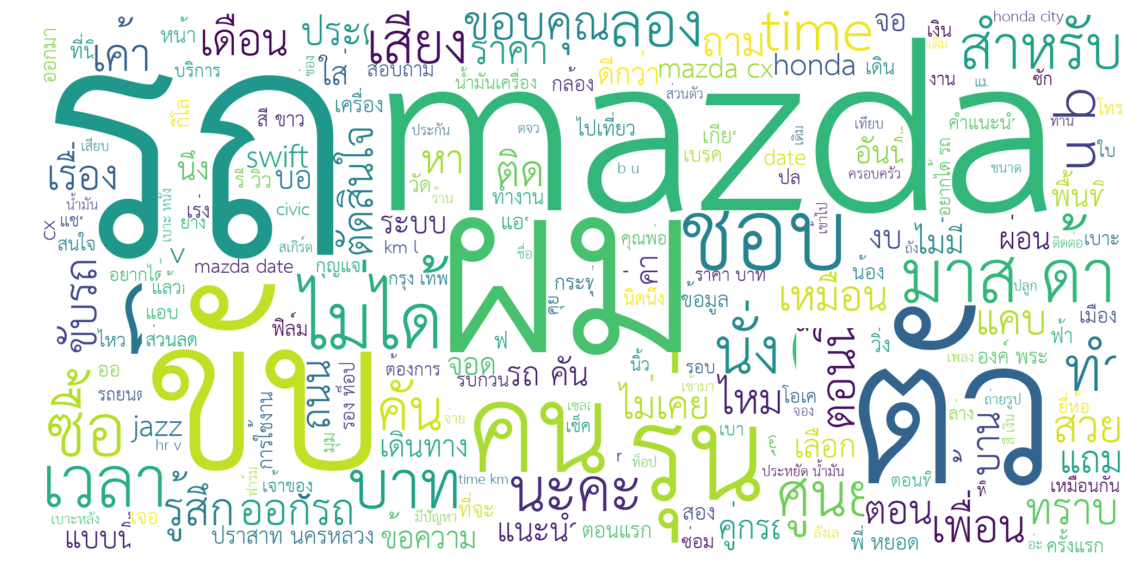

In [31]:
# Generate a word cloud image
wordcloud = WordCloud(font_path='THSarabunNew.ttf', # path ที่ตั้ง Font
                      width=2000,
                      height=1000,
                      stopwords = ' '.join(thai_stopwords()) , # ลบคำที่ไม่ใช้ออก
                      background_color="white", # ตั้งค่าพืสี้นหลัง
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(segment_tkns))

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

In [32]:
# generate word vector plot
enc_segment_tkns = [stoi[tkn] for tkn in segment_tkns]

# delete unknown tokens
del_idxs = []
for i in range(len(enc_segment_tkns)):
    if enc_segment_tkns[i] == -1:
        del_idxs.append(i)

for i in sorted(del_idxs,reverse=True):
    del enc_segment_tkns[i]

all_tkn = list(set(enc_segment_tkns))
comp_emb_mat = TSNE(n_components=2).fit_transform(emb_mat[all_tkn,:])

tkn2emb_in = dict()
for i,tkn in enumerate(all_tkn):
    tkn2emb_in[tkn] = i

topn_idx = [idx for idx,_ in Counter(enc_segment_tkns).most_common(200)]
labels = [itos[idx] for idx in topn_idx]

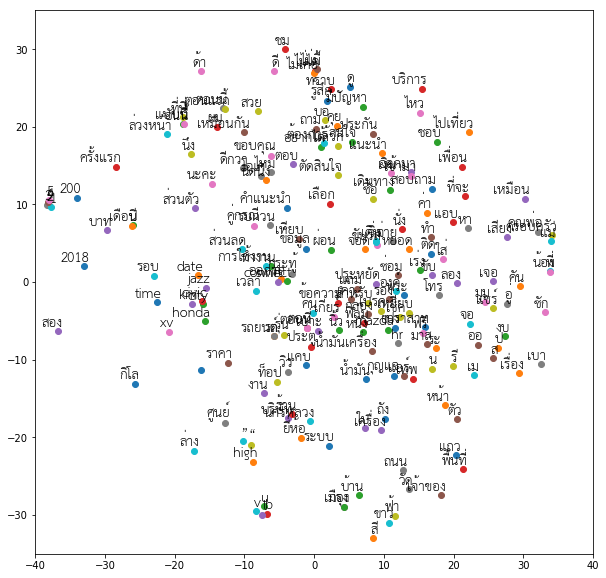

In [35]:
plot_with_labels(comp_emb_mat[[tkn2emb_in[tkn] for tkn in topn_idx],:],labels,axis_lims=[-40,40,-35,35])

### export to excel

In [10]:
sel_comp_emb_mat = comp_emb_mat[[tkn2emb_in[tkn] for tkn in topn_idx],:]
# export to excel
pd.DataFrame({'word':labels, 'x':sel_comp_emb_mat[:,0], 'y':sel_comp_emb_mat[:,1]}).to_excel('../out/wv_segment5.xlsx',index=False)

## segment 3

In [36]:
segment_idx = df_temp[df_temp['segment'] == 3].index
segment_tkns = [tkn for idx in segment_idx for tkn in tokens_post[idx]]

del_list = ['number']
del_idxs = []
for i in range(len(segment_tkns)):
    if segment_tkns[i] in del_list:
        del_idxs.append(i)
        
for i in sorted(del_idxs,reverse=True):
    del segment_tkns[i]

(-0.5, 1999.5, 999.5, -0.5)

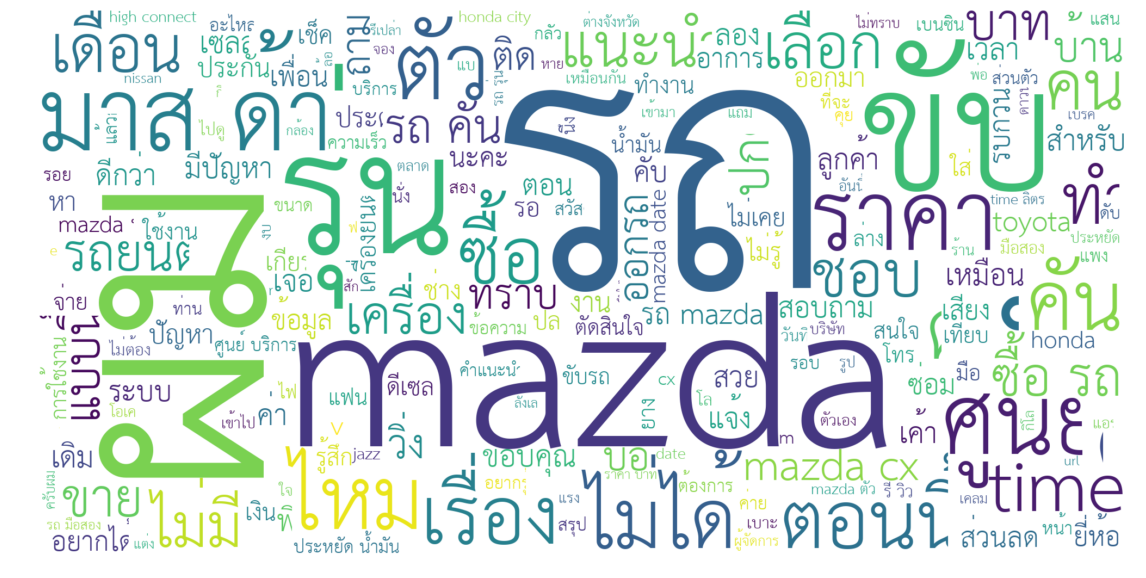

In [37]:
# Generate a word cloud image
wordcloud = WordCloud(font_path='THSarabunNew.ttf', # path ที่ตั้ง Font
                      width=2000,
                      height=1000,
                      stopwords = ' '.join(thai_stopwords()) , # ลบคำที่ไม่ใช้ออก
                      background_color="white", # ตั้งค่าพืสี้นหลัง
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(segment_tkns))

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")

In [38]:
# generate word vector plot
enc_segment_tkns = [stoi[tkn] for tkn in segment_tkns]

del_idxs = []
for i in range(len(enc_segment_tkns)):
    if enc_segment_tkns[i] == -1:
        del_idxs.append(i)

for i in sorted(del_idxs,reverse=True):
    del enc_segment_tkns[i]

all_tkn = list(set(enc_segment_tkns))
comp_emb_mat = TSNE(n_components=2).fit_transform(emb_mat[all_tkn,:])

tkn2emb_in = dict()
for i,tkn in enumerate(all_tkn):
    tkn2emb_in[tkn] = i

topn_idx = [idx for idx,_ in Counter(enc_segment_tkns).most_common(200)]
labels = [itos[idx] for idx in topn_idx]

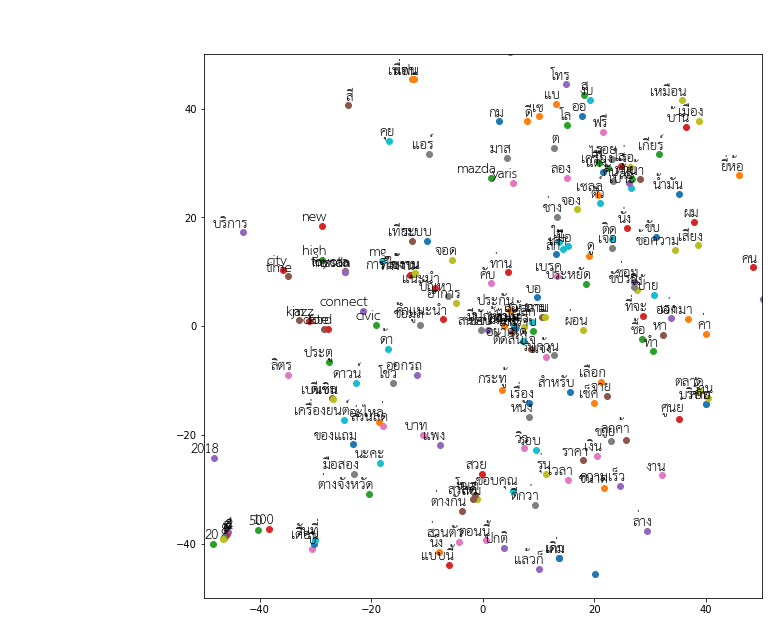

In [39]:
plot_with_labels(comp_emb_mat[[tkn2emb_in[tkn] for tkn in topn_idx],:],labels,axis_lims=[-50,50,-50,50])

In [15]:
# export to excel
pd.DataFrame({'word':labels, 'x':sel_comp_emb_mat[:,0], 'y':sel_comp_emb_mat[:,1]}).to_excel('../out/wv_segment3.xlsx',index=False)